In [ ]:
# Step 1: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MultiLabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, roc_auc_score, RocCurveDisplay
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings("ignore")

# Set style for plots
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8,5)

In [ ]:
# Step 2: Load Data with Basic Checks
def load_csv(file_name):
    try:
        df = pd.read_csv(file_name)
        print(f"{file_name} loaded successfully → shape: {df.shape}")
        return df
    except FileNotFoundError:
        print(f"⚠️ File {file_name} not found. Please check the path.")
        return None

users = load_csv("Users.csv")
posts = load_csv("Posts.csv")
engagements = load_csv("Engagements.csv")

Users.csv loaded successfully → shape: (50, 5)
Posts.csv loaded successfully → shape: (100, 4)
Engagements.csv loaded successfully → shape: (1000, 3)


In [ ]:
# Step 3: Check data quality
print("\nChecking data quality...")


Checking data quality...


In [ ]:

# Check for missing values across all datasets
print("\nMissing values in Users:")
print(users.isnull().sum())
print("\nMissing values in Posts:")
print(posts.isnull().sum())
print("\nMissing values in Engagements:")
print(engagements.isnull().sum())


Missing values in Users:
user_id                  0
age                      0
gender                   0
top_3_interests          0
past_engagement_score    0
dtype: int64

Missing values in Posts:
post_id         0
creator_id      0
content_type    0
tags            0
dtype: int64

Missing values in Engagements:
user_id       0
post_id       0
engagement    0
dtype: int64


In [ ]:
# Basic info
print("\nUsers Data Types:")
print(users.dtypes)
print("\nPosts Data Types:")
print(posts.dtypes)
print("\nEngagements Data Types:")
print(engagements.dtypes)


Users Data Types:
user_id                   object
age                        int64
gender                    object
top_3_interests           object
past_engagement_score    float64
dtype: object

Posts Data Types:
post_id         object
creator_id      object
content_type    object
tags            object
dtype: object

Engagements Data Types:
user_id       object
post_id       object
engagement     int64
dtype: object


In [ ]:
# Step 4: EDA
# Display first few rows of each dataset
print("\nUsers head:")
print(users.head())
print("\nPosts head:")
print(posts.head())
print("\nEngagements head:")
print(engagements.head())


Users head:
  user_id  age gender          top_3_interests  past_engagement_score
0      U1   24      F      sports, art, gaming                   0.61
1      U2   32      F    travel, food, fashion                   0.93
2      U3   28  Other  sports, travel, fashion                   0.40
3      U4   25      M     fashion, music, tech                   0.53
4      U5   24      M   fashion, food, fitness                   0.80

Posts head:
  post_id creator_id content_type            tags
0      P1        U44        video    sports, food
1      P2        U26        video   music, travel
2      P3        U32         text  sports, travel
3      P4         U6        image   music, gaming
4      P5        U32        image   food, fashion

Engagements head:
  user_id post_id  engagement
0      U1     P52           1
1      U1     P44           0
2      U1      P1           1
3      U1      P4           1
4      U1     P65           0


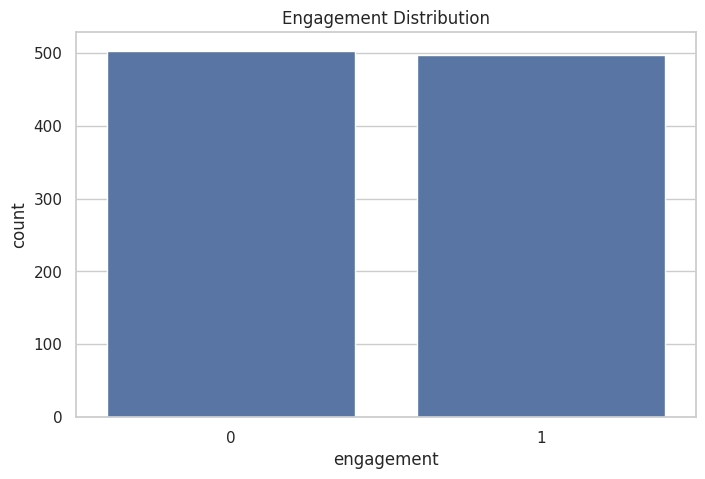

In [ ]:
# Distribution of engagement (target)
sns.countplot(x='engagement', data=engagements)
plt.title("Engagement Distribution")
plt.show()

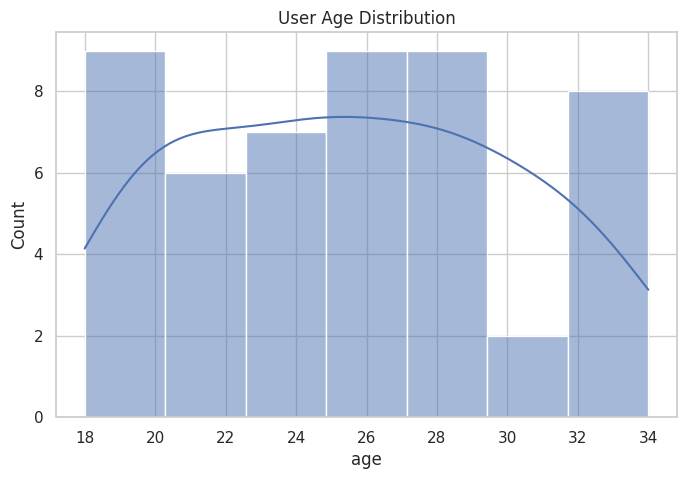

In [ ]:
# Age distribution in users
sns.histplot(users['age'], kde=True)
plt.title("User Age Distribution")
plt.show()

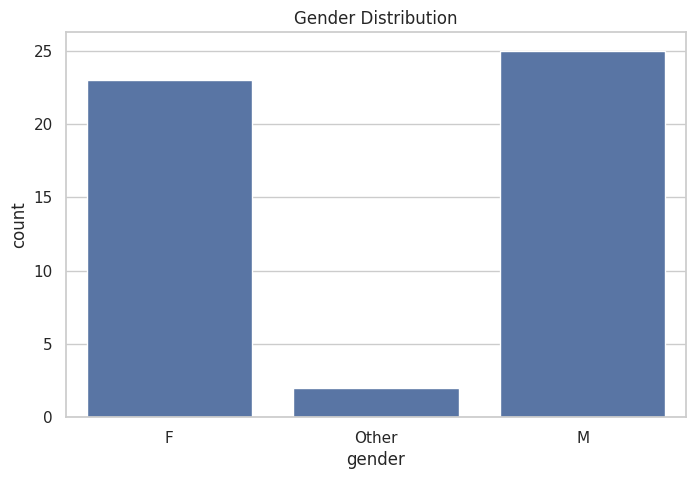

In [ ]:
# Gender distribution
sns.countplot(x='gender', data=users)
plt.title("Gender Distribution")
plt.show()

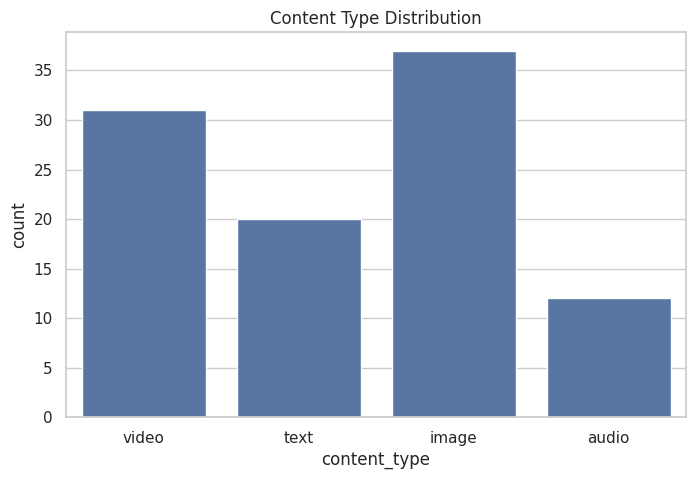

In [ ]:
# Content type distribution in posts
sns.countplot(x='content_type', data=posts)
plt.title("Content Type Distribution")
plt.show()

In [ ]:
# Step 5: Data Preprocessing and Feature Engineering
# Merge datasets: Engagements with Users on user_id, and with Posts on post_id
merged_df = engagements.merge(users, on='user_id', how='left')
merged_df = merged_df.merge(posts, on='post_id', how='left')

In [ ]:
# Drop unnecessary columns (IDs, but keep creator_id for potential features if needed)
# For now, we'll drop creator_id as we're not using creator features
merged_df = merged_df.drop(columns=['user_id', 'post_id', 'creator_id'])

In [ ]:
# Handle multi-label columns: top_3_interests and tags
# Split strings into lists
merged_df['top_3_interests'] = merged_df['top_3_interests'].apply(lambda x: [i.strip() for i in x.split(',')])
merged_df['tags'] = merged_df['tags'].apply(lambda x: [i.strip() for i in str(x).split(',')])

In [ ]:
# Feature: Interest match count (how many user interests overlap with post tags)
merged_df['interest_match'] = merged_df.apply(lambda row: len(set(row['top_3_interests']) & set(row['tags'])), axis=1)

In [ ]:
# Now, for modeling, we'll use MultiLabelBinarizer for interests and tags
mlb_interests = MultiLabelBinarizer()
interests_encoded = pd.DataFrame(mlb_interests.fit_transform(merged_df['top_3_interests']),
                                 columns=mlb_interests.classes_,
                                 index=merged_df.index)

mlb_tags = MultiLabelBinarizer()
tags_encoded = pd.DataFrame(mlb_tags.fit_transform(merged_df['tags']),
                            columns=mlb_tags.classes_,
                            index=merged_df.index)

In [ ]:
# Concatenate encoded features back to merged_df
merged_df = pd.concat([merged_df.drop(columns=['top_3_interests', 'tags']), interests_encoded, tags_encoded], axis=1)


In [ ]:
# Define target
target_col = 'engagement'
X = merged_df.drop(columns=[target_col])
y = merged_df[target_col]

In [ ]:
# Identify categorical and numerical columns
categorical_cols = ['gender', 'content_type']  # Add more if needed
numerical_cols = ['age', 'past_engagement_score', 'interest_match']  # Numerical features
binary_cols = list(interests_encoded.columns) + list(tags_encoded.columns)  # Already binary, no need to encode

In [ ]:
# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_cols)
    ],
    remainder='passthrough'  # Keep binary columns as is
)

In [ ]:
# Apply preprocessing
X_preprocessed = preprocessor.fit_transform(X)

In [ ]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_preprocessed, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
# Step 6: Model Training
model = LogisticRegression(random_state=42, class_weight='balanced')  # Balanced for potential class imbalance
model.fit(X_train, y_train)

LogisticRegression(class_weight='balanced', random_state=42)

In [ ]:
# Step 7: Evaluation
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

print("\nAccuracy:", accuracy_score(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nROC AUC Score:", roc_auc_score(y_test, y_pred_proba))



Accuracy: 0.485

Confusion Matrix:
 [[52 49]
 [54 45]]

Classification Report:
               precision    recall  f1-score   support

           0       0.49      0.51      0.50       101
           1       0.48      0.45      0.47        99

    accuracy                           0.48       200
   macro avg       0.48      0.48      0.48       200
weighted avg       0.48      0.48      0.48       200


ROC AUC Score: 0.48829882988298834


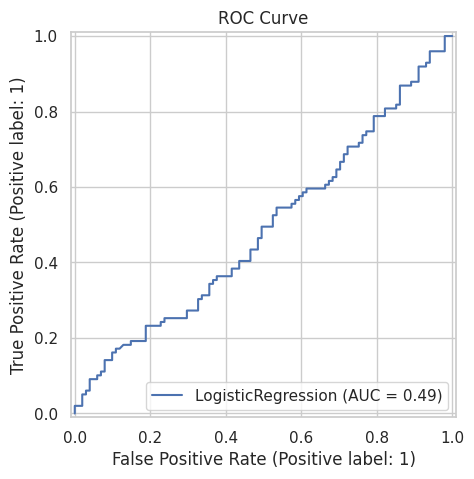

In [ ]:
# ROC Curve
RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.title("ROC Curve")
plt.show()

In [ ]:
# Confusion Matrix Heatmap
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()